# Test.ipynb

## Collaborators: Ryan Peruski, Jake Marlow, Sam Lavey

## Objective: Use different Classical Machine Learning Methods on a given Kaggle Dataset to predict whether or not a Credit Card Transaction is Fraudulent

### Methods Currently Used: 
1. Logistic Regression
2. K Nearest Neighbors
3. Ridge Regularization
4. Support Vector Machine

### Kaggle Dataset:
https://www.kaggle.com/datasets/neharoychoudhury/credit-card-fraud-data/data

### Code Sources
1. SKLearn, Matplotlib, Seaborn Documentation
2. Previous HW's and a HW from a Data Science Class
3. Help from AI tools for boiler-plate code and debugging


In [2]:
# Tons of imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import seaborn as sns # For confusion matrix -- I know we have plt but this is better for that specific situation
import warnings


#Global variables -- random state is for train_test split and thres is the threshold for the confidence score (if x > thres, then it IS fraud (1))
#In reality, we would want to not use a random state, but this is for reproducibility for the sake of this project
RANDOM_STATE = 42
THRES = 0.5
SAVE = True # This is just a variable I used to save all the plots instead of showing them
SAVE_DIR = 'Data/Figs/' # Directory to save the plots (Only works if SAVE is True, obviously)

# read the data (obviously change this if you're not using the same directory)
data = pd.read_csv('Data/fraud_data.csv')

# Suppress warnings
warnings.filterwarnings("ignore")

data

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14441,22-01-2019 00:37,Hudson-Grady,shopping_pos,122.00,Athena,OR,45.8289,-118.4971,1302,Dealer,18-10-1976,699a4c06b22711bf3e0d8ef91232d356,46.442439,-118.524214,0
14442,22-01-2019 00:41,"""Nienow, Ankunding and Collie""",misc_pos,9.07,Gardiner,OR,43.7857,-124.1437,260,"""Engineer, maintenance""",01-09-1956,080d620d24815c7d6c637cf0b71dde8e,42.901265,-124.995317,0
14443,22-01-2019 00:42,Pacocha-O'Reilly,grocery_pos,104.84,Alva,WY,44.6873,-104.4414,110,"""Administrator, local government""",16-05-1973,3c346c8cd627c5fe3ed57430db2e9ae7,45.538062,-104.542117,0
14444,22-01-2019 00:48,"""Bins, Balistreri and Beatty""",shopping_pos,268.16,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,e66ffcc95ba7fc490486242af1205d04,64.081462,-165.898698,0


## Data Normalization Step
1. Drop any rows with NaN/missing values
2. Make sure that the dependent variable is a binary "1" or "0"
3. Make sure that the independent variables are all numerical (for now, we are omitting categorical variables)
4. Split into training and testing data and use a Standard Scaler to normalize the data

In [3]:
#Oops! The data somehow is not cleaned properly. Let's clean it first.
# drop the rows with missing values
data = data.dropna()

#Make sure is_fraud is a binary variable. Remove those that aren't 0 or 1

data = data[(data["is_fraud"] == "0") | (data["is_fraud"] == "1")]

data["is_fraud"] = data["is_fraud"].astype(int)

data["is_fraud"].unique()

array([1, 0])

In [4]:
# Features and target variable
X = data[['lat', 'long', 'amt', 'city_pop', 'merch_lat', 'merch_long']]
y = data['is_fraud'].astype(int)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE) #I'm filling a random seed here just to make testing code consistent

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (11555, 6)
X_test shape: (2889, 6)
y_train shape: (11555,)
y_test shape: (2889,)


In [5]:
#Let's scale the data -- this is just basically using the same code from the HW's
scaler = StandardScaler()

# Scale the training data
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test data
X_test_scaled = scaler.fit_transform(X_test)

## K-Nearest Neighbors
1. Find the optimal number of neighbors using a for loop -- the metric we are using is the R2 score (as done in previous homeworks)
2. Plot Confusion Matrix and ROC Curve as well as the different scores used for the midterm report.

In [6]:
# Define the values for n_neighbors to be tested
n_neighbors_list = [1, 3, 5, 10, 50, 100, 110]
best_r2 = -float('inf')
best_k = None

# Iterate over each value of n_neighbors
for k in n_neighbors_list:

    # Create and train the KNN
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test_scaled)
    
    # Calculate the R^2 score
    r2 = r2_score(y_test, y_pred)
    
    # Print the R^2 score for the current value of n_neighbors
    print(f"n_neighbors: {k}, R^2 Score: {r2:.2f}")

    # Update the best R^2 score and best value of n_neighbors
    if r2 > best_r2:
        best_r2 = r2
        best_k = k

print(f"Best n_neighbors: {best_k}, Best R^2 Score: {best_r2:.2f}")

n_neighbors: 1, R^2 Score: 0.40
n_neighbors: 3, R^2 Score: 0.55
n_neighbors: 5, R^2 Score: 0.60
n_neighbors: 10, R^2 Score: 0.60
n_neighbors: 50, R^2 Score: 0.56
n_neighbors: 100, R^2 Score: 0.52
n_neighbors: 110, R^2 Score: 0.52
Best n_neighbors: 10, Best R^2 Score: 0.60


Note: This block of code is used multiple times throughout the notebook to plot whatever is needed (with a few changes here and there). Here is the gist of this code:
1. Initializes and Fits the model.
2. Does predictions on the test data.
3. Gets BOTH binary representations of the predictions (>THRES is a 1 and <= is a 0, see THRES above) and the probabilities of the predictions (simple lambda function for this). Binary predictions must be used for the confusion matrix as well as the f1 scores and accuracy scores, but the probabilities are used for a smoother ROC curve as well as the R² score.
4. Finally, the corresponding plots are made and scores are calculated. Most of this code was directly from previous homeworks, but we added the ROC curve plots. We hope the code is relatively straightforward to understand, since most of it is just using the sklearn library.

Mean Squared Error: 0.05
R² Score: 0.60
F1 Score: 0.79
Accuracy Score: 0.95


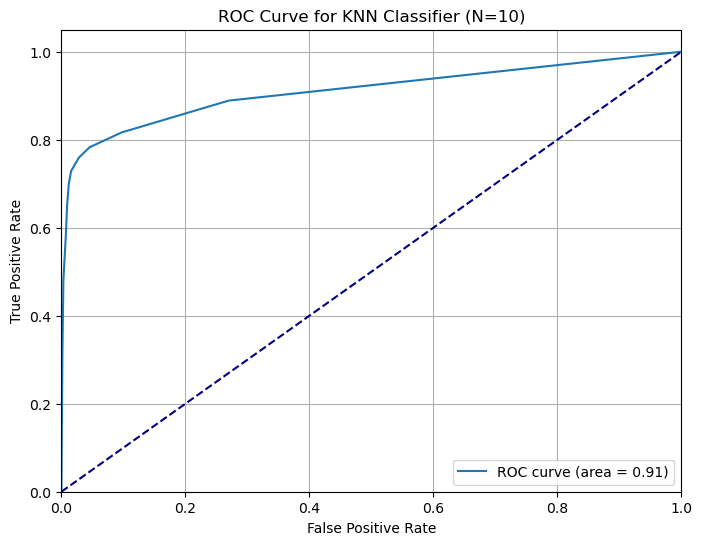

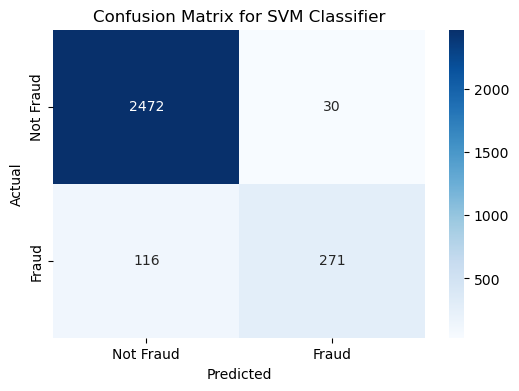

In [7]:
# Initialize the K-Nearest Neighbors Regressor with the best k value
best_model = KNeighborsRegressor(n_neighbors=best_k)

# Fit the model using the scaled training data
best_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data using the trained KNN model
y_pred = best_model.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE) between the predicted and actual values
mse_knn = mean_squared_error(y_test, y_pred)

# Calculate the R^2 score for the model
r2_knn = r2_score(y_test, y_pred)

#Convert y_pred to a series of 0s and 1s
y_pred_bin = pd.Series(y_pred).apply(lambda x: 1 if x > THRES else 0)

# f1 and accuracy score
f1_knn = f1_score(y_test, y_pred_bin)
acc_knn = accuracy_score(y_test, y_pred_bin)

# Print the MSE and R^2 score rounded to 2 decimal places
print(f"Mean Squared Error: {mse_knn:,.2f}")
print(f"R² Score: {r2_knn:.2f}")
print(f"F1 Score: {f1_knn:.2f}")
print(f"Accuracy Score: {acc_knn:.2f}")

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for KNN Classifier (N={best_k})')
plt.legend(loc='lower right')
plt.grid(True)
if not SAVE:
    plt.show()
else:
    plt.savefig(SAVE_DIR + 'roc_curve_knn.png')

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_bin)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix for SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
if not SAVE:
    plt.show()
else:
    plt.savefig(SAVE_DIR + 'confusion_matrix_knn.png')

## Simple Vector Machine (SVM)

Mean Squared Error (MSE): 0.08
R² Score: 0.31
Accuracy: 0.92
F1 Score: 0.62


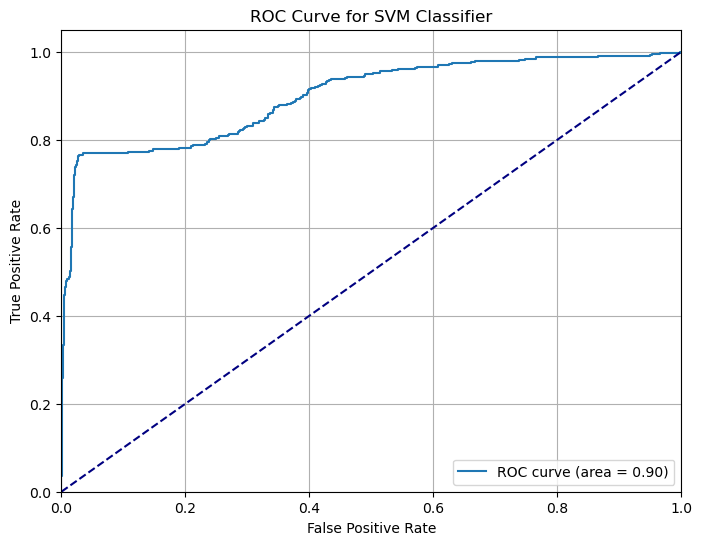

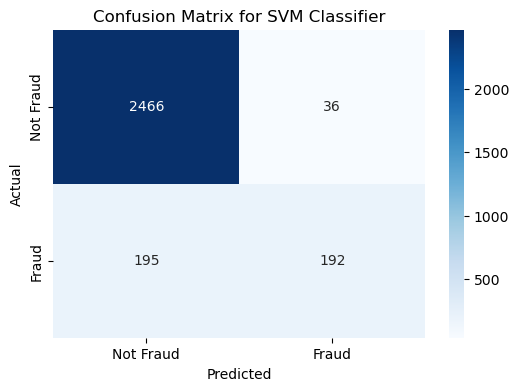

In [8]:
# using the svm method on the data now

clf = svm.SVC()
# Fit the SVM model using the scaled training data
clf.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_pred_svm = clf.predict(X_test_scaled)

# Calculate MSE
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f"Mean Squared Error (MSE): {mse_svm:.2f}")

# Calculate R² score
r2_svm = r2_score(y_test, y_pred_svm)
print(f"R² Score: {r2_svm:.2f}")

#Get the accuracy and f1 score
accuracy = clf.score(X_test_scaled, y_test)
f1 = f1_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

# Get probability estimates from the SVM model (use `decision_function` for SVMs) (basically the confidence of the model, and the opposite of what we had to do with KNN)
y_prob_svm = clf.decision_function(X_test_scaled)

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_svm)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classifier')
plt.legend(loc='lower right')
plt.grid(True)
if not SAVE:
    plt.show()
else: 
    plt.savefig(SAVE_DIR + 'roc_curve_svm.png')

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix for SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
if not SAVE:
    plt.show()
else:
    plt.savefig(SAVE_DIR + 'confusion_matrix_svm.png')


## Ridge (L2) Regularization

Mean Squared Error: 0.07
R² Score: 0.52
F1 Score: 0.61
Accuracy Score: 0.92


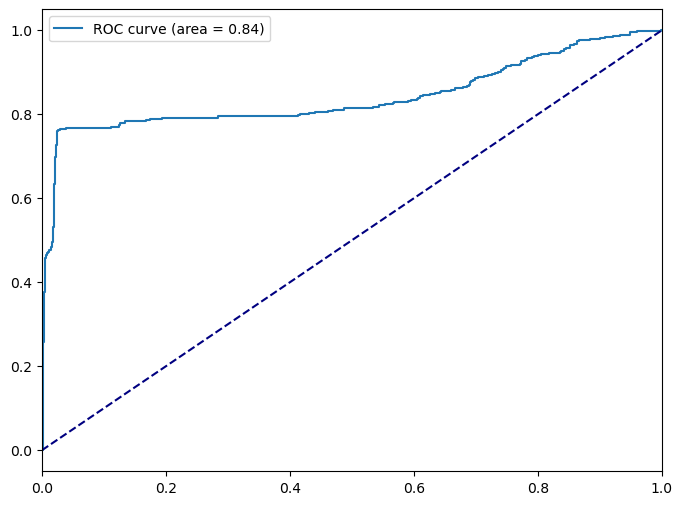

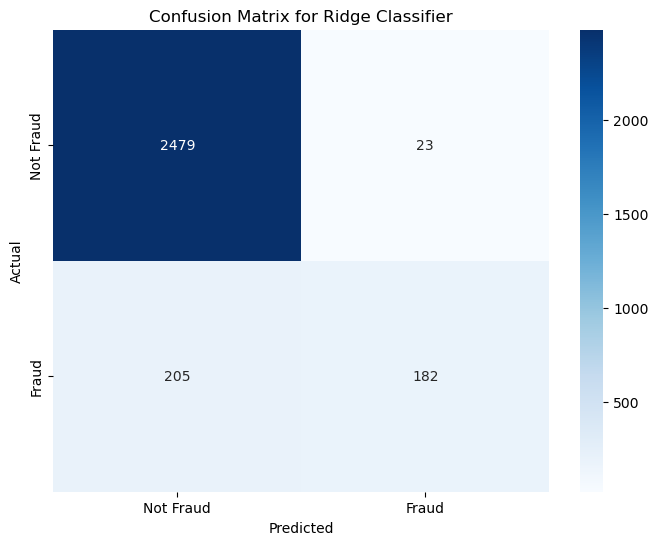

In [9]:
#Now that we have two models and initial results, let's use regularization
# We should use L2 (Ridge) regularization for both models, since we do not have very many dimensions in our data -- L1 (Lasso) regularization is better suited for high-dimensional data.

# Initialize the Ridge model
ridge = Ridge(alpha=1.0)

# Fit the Ridge model using the scaled training data
ridge.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data using the Ridge model
y_pred = ridge.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE) between the predicted and actual values for Ridge
mse = mean_squared_error(y_test, y_pred)

# Calculate the R^2 score for the Ridge and Lasso models
r2_ridge = r2_score(y_test, y_pred)

#convert to either 0 or 1
y_pred_bin = pd.Series(y_pred).apply(lambda x: 1 if x > THRES else 0)

#get f1 and accuracy score
f1 = f1_score(y_test, y_pred_bin)
accuracy = accuracy_score(y_test, y_pred_bin)

# Print the MSE and R^2 score for Ridge and Lasso models
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy Score: {accuracy:.2f}")

# Calculate the ROC curve for Ridge and Lasso models
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_ridge = auc(fpr, tpr)

# Plot the ROC curve for Ridge and Lasso models
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_ridge:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.legend()
if not SAVE:
    plt.show()
else:
    plt.savefig(SAVE_DIR + 'roc_curve_ridge.png')

# Generate the confusion matrix for Ridge and Lasso models
cm_ridge = confusion_matrix(y_test, y_pred_bin)

# Plot the confusion matrix using seaborn for Ridge and Lasso models
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ridge, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix for Ridge Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
if not SAVE:
    plt.show()
else:
    plt.savefig(SAVE_DIR + 'confusion_matrix_ridge.png')


## Logistic Regression

Mean Squared Error: 0.08
R² Score: 0.52
F1 Score: 0.61
Accuracy Score: 0.92


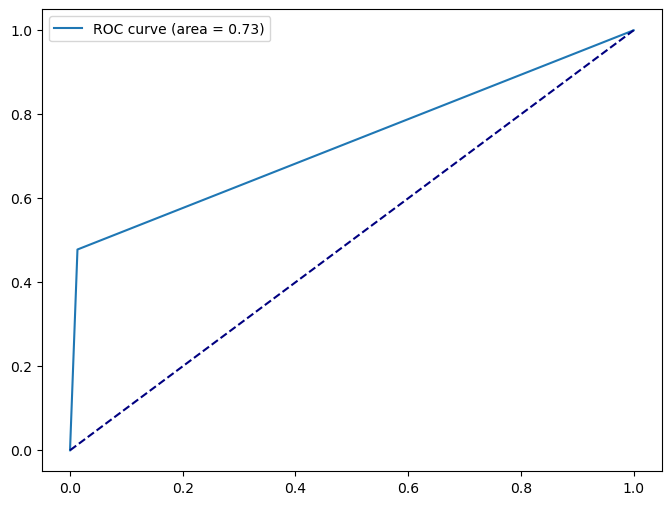

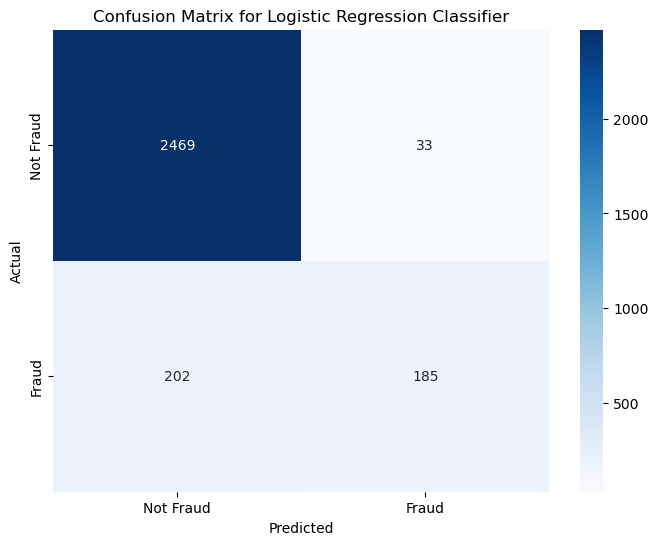

In [10]:
# Finally, let's do a logistic regression model

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Fit the Logistic Regression model using the scaled training data
log_reg.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data using the Logistic Regression model
y_pred = log_reg.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE) between the predicted and actual values for Logistic Regression
mse = mean_squared_error(y_test, y_pred)

# Calculate the R^2 score for the Logistic Regression model
r2_log_reg = r2_score(y_test, y_pred)

#convert to either 0 or 1

y_pred_bin = pd.Series(y_pred).apply(lambda x: 1 if x > THRES else 0)

#get f1 and accuracy score
f1 = f1_score(y_test, y_pred_bin)
accuracy = accuracy_score(y_test, y_pred_bin)

# Print the scores for Logistic Regression model
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy Score: {accuracy:.2f}")

# Calculate the ROC curve for Logistic Regression model
fpr, tpr, _ = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve for Logistic Regression model
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()
if not SAVE:
    plt.show()
else:
    plt.savefig(SAVE_DIR + 'roc_curve_log_reg.png')

# Plot the confusion matrix using seaborn for Logistic Regression model
cm = confusion_matrix(y_test, y_pred_bin)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix for Logistic Regression Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')

if not SAVE:
    plt.show()
else:
    plt.savefig(SAVE_DIR + 'confusion_matrix_log_reg.png')


### One More Unique Plot
One more thing that we want to show is some sort of plot that almost shows "clusters" that SHOULD BE formed by a model in an optimal setting. However, we can really only display three variables out of the six that we have. Therefore, we have to get creative and choose three of the six variables that we think are the most important. The idea is to choose the three variables that have the highest correlation with the dependent variable. We will then plot these three variables in a 3D plot and color the points based on whether or not they are fraudulent. This will give us a good idea of how the model should be clustering the data, as well as which variables are most important. After consulting the internet and some AI assistance, we found that the best way to choose the variables is to do a simple Random Forest Classifier and then look at the feature importances. We will then choose the three variables with the highest feature importances and plot them in a 3D plot.

To reiterate, we are plotting the GROUND TRUTHS in the test data here. This is merely to get an idea of which factors are most important in determining whether or not a transaction is fraudulent. We are not plotting the predictions of any model.

1. Declare the feature names in the correct order.
2. Fit the Random Forest Classifier and get the feature importances.
3. Choose the three variables with the highest feature importances.
4. Plot the 3D plot with the colors based on whether or not the data is fraudulent.


Top 3 features: ['amt', 'merch_lat', 'merch_long']


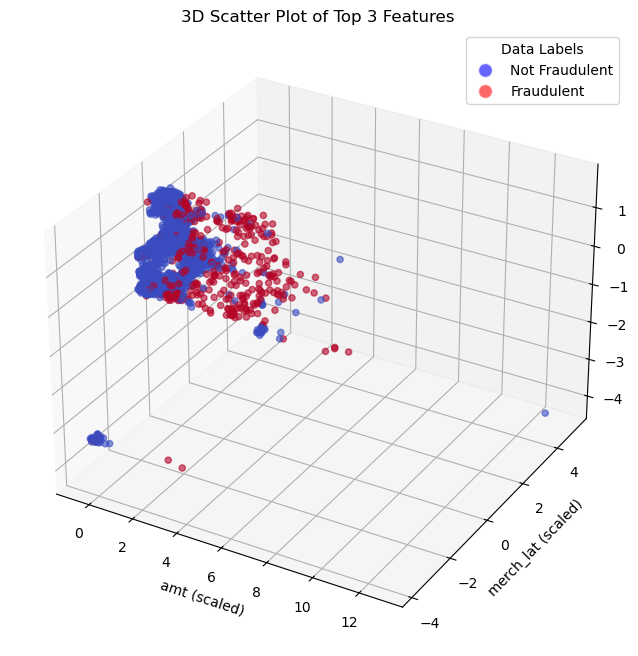

In [11]:
# Grab the names of the features
feature_names = X.columns

# Train a Random Forest model purely to get feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf.fit(X_train_scaled, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:3]  # Get the indices of the top 3 features

# Print the names of the top 3 features
top_features = [feature_names[i] for i in indices]
print(f"Top 3 features: {top_features}")

# For convenience in plotting the labels, let's acknowledge that the top 3 features are scaled

for i, feat in enumerate(top_features):
    top_features[i] = f"{feat} (scaled)"

# Plot the data using the top 3 features

# I (Ryan) have plotted 3D plots before in another class, so I mainly copied the code from there.
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(X_test_scaled[:, indices[0]], X_test_scaled[:, indices[1]], X_test_scaled[:, indices[2]], c=y_test, cmap='coolwarm', alpha=0.6)
ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_zlabel(top_features[2])
ax.set_title('3D Scatter Plot of Top 3 Features')

# Create a custom legend (I tried to automate this, but it was too much of a hassle, so I have approximated the colors for the legend)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="blue", markersize=10, label="Not Fraudulent", alpha=0.6),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="red", markersize=10, label="Fraudulent", alpha=0.6),]
ax.legend(handles=handles, title='Data Labels')

if not SAVE:
    plt.show()
else:
    plt.savefig(SAVE_DIR + '3d_scatter_plot.png')

As we can see, the "amt" feature seems to be the most important feature, as the low amounts are typically not fraudulent and the high amounts are typically fraudulent.

## Future Prospects

In [12]:
#From all of this data, we can see that each model has its own strengths and weaknesses.
#Thus, it's time to ensemble these models and, potentially, look into something like Majority Voting
#Also, we should look into encoding categorical variables to get better results.

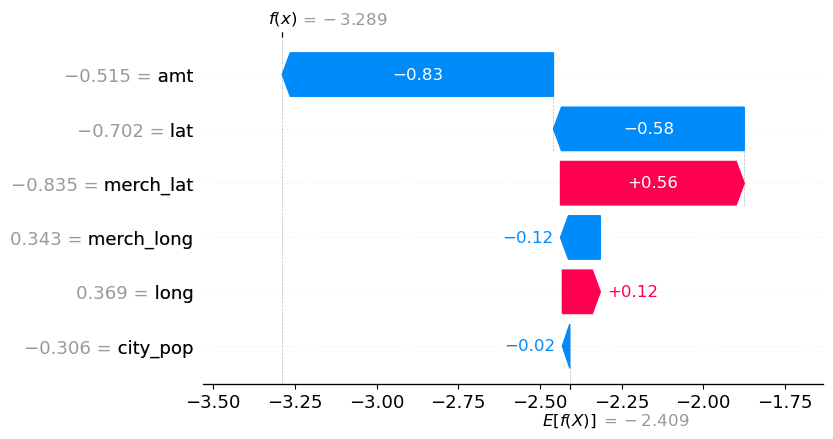

In [15]:
# this code segment implements the SHAP method

import shap

explainer = explainer = shap.Explainer(log_reg, masker = X_train_scaled, feature_names = feature_names)
shap_values = explainer(X_test_scaled)
shap.plots.waterfall(shap_values[5], max_display = 15)

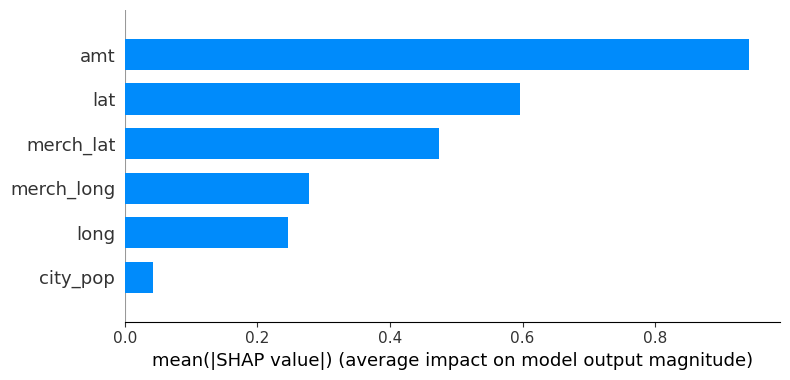

In [14]:
shap.summary_plot(shap_values, X_test_scaled, plot_type = "bar")